In [1]:
import boto3
import io
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

#import awswrangler as wr
#import s3fs
#from fastparquet import write

import joblib

#modeling
import statsmodels.api as sm
from statsmodels.api import add_constant
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,ShuffleSplit, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay,\
classification_report, accuracy_score, f1_score, precision_recall_curve
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
import sklearn.metrics as metrics
from sklearn.metrics import make_scorer, roc_auc_score, log_loss, brier_score_loss
from sklearn.utils import resample


import lightgbm as lgbm

plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings("ignore")

### Data Load

In [2]:
df =  pd.read_parquet('model_ready.parquet')

In [4]:
df.shape

(4375253, 246)

In [3]:
#### out-date
out_date = '2022-06'

In [ ]:
### additional features

In [4]:
df['policy_age_diff_aum']=df['policy_age']/12*df['diff_aum_cash_val']

In [5]:
df['policy_age_cash1']=df['policy_age']/12*df['mod_mpt_total']
df['policy_age_cash2']=df['policy_age']/12*df['mpt_total_bld_face_amt']

In [6]:
df['holder_age_cash1']=df['holder_age']*df['mod_mpt_total']
df['holder_age_cash2']=df['holder_age']*df['mpt_total_bld_face_amt']

In [7]:
df['issue_age_cash1']=df['issue_age']*df['mod_mpt_total']
df['issue_age_cash2']=df['issue_age']*df['mpt_total_bld_face_amt']

In [8]:
df['diff_cash_holder_issue1']=df['holder_age_cash1']-df['issue_age_cash1']
df['diff_cash_holder_issue2']=df['holder_age_cash2']-df['issue_age_cash2']

### filters

In [14]:
# # remove low cash in later policy life
# df['policy_age_300'] = np.where(df['policy_age']>300, 1, 0)
# df['remove'] = np.where( (df['policy_age_300']==1)&(df['cash_val_bucket']=='1_$0k-10k'),1,0)

# df= df[df['remove']!=1]
# print(df.shape)

(3850915, 257)


### Performance Metrics

In [9]:
#roc curve
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

In [10]:
def fn_importance_features(model):
    clf = model
    feature_importances_data = []
    features = train_X.columns
    for feature_name, feature_importance in zip(features, clf.feature_importances_):
        feature_importances_data.append({
            'feature': feature_name,
            'importance': feature_importance
        })

    # Plot the results
    pd.DataFrame(feature_importances_data)\
        .set_index('feature')\
        .sort_values(by='importance')[-30::]\
        .plot(title='Top 20 most important features: '+ str(type(model).__name__),
              kind='barh',figsize=(10, 6),
              color='#348ABD',alpha=0.6,
              lw='1', edgecolor='#348ABD',grid=False,)

In [11]:
#key performance metrics
def fn_metrics(act, prob, pred):
    #ROC
    fpr, tpr, thresholds = roc_curve(act, prob)
    roc_auc = auc(fpr, tpr)
    plot_roc_curve(fpr, tpr)
    
    print ('ROC value of:{:.2f}'.format(roc_auc*100))
    print ('Accuracy:{:.2f}'.format(accuracy_score(act, pred)*100))
    print ('F1 score:{:.2f}'.format(f1_score(act, pred)*100))
    print ('Recall:{:.2f}'.format(recall_score(act, pred)*100))
    print ('Precision:{:.2f}'.format(precision_score(act, pred)*100))
    print ('\n clasification report:\n',classification_report(act, pred))
     
    #plot confusion matrix    
    fig, ax = plt.subplots(1,1,figsize=(8,6))
    plt.rcParams.update({'font.size': 16})
    ConfusionMatrixDisplay(confusion_matrix(pred, act, labels=[1,0]), 
                       display_labels=['3mo_ahead_lapse','No_Lapse']).plot(values_format=".0f",ax=ax)

    ax.set_xlabel("Actual Label")
    ax.set_ylabel("Predicted Label")
    plt.show()

In [14]:
# df_dtypes = df.dtypes.to_frame('dtypes').reset_index().rename(columns = {"index":"Columns"})
# df_missing = pd.DataFrame(df.isnull().sum()/len(df)).reset_index().rename(columns = {"index":"Columns", 0:"Missing%"})
# df_unique =pd.DataFrame(df.nunique()).reset_index().rename(columns = {"index":"Columns", 0:"# of Unique Values"})
# df_summary = df_dtypes.merge(df_missing, on='Columns', how='inner').merge(df_unique, on='Columns', how='inner')
# df_summary.out = df_summary.to_csv("df_summary.csv",  header=True)
# df_summary

,Columns,dtypes,Missing%,# of Unique Values
0,month,int64,0.000000e+00,6
1,agmt_pkge_id,object,0.000000e+00,736008
2,aos_status_code,object,0.000000e+00,12
3,val_inforce_cls,object,0.000000e+00,4
4,kind_code,object,0.000000e+00,99
5,sub_kind,object,0.000000e+00,3
6,conv_undrwrt_code,object,8.261606e-01,2
7,conv_type,object,8.259245e-01,6
8,spec_id,int64,0.000000e+00,166
9,premium_basis,int64,0.000000e+00,7


### Features

In [12]:
features =[
#target
'3mo_ahead_Lapse',
'pfmc_cur_month',

#categorical
'current_status',
'holder_age_bucket',
'cash_val_bucket',
'issue_yr_cohort',
'gndr_cd',
'prem_mode',
'val_inforce_cls',
'lob_group',
'prod_grp',
'mrtl_stat_cd',
'place_abbrev',
#'rtl_dstrb_orphn_cd',
'aos_status_code',
'smoking_habit',
'conv_type',
'premium_basis',
'tax_basis',
'div_option',
'spec_und_code',
'medical_issue_cd',
'pension_code',
'pgls_product_code',
'int_loan_typ_cd',
'abbr_pay_typ_cd',
'opr_stat_cd',
'pln_id',
'prem_pattern_cd',
'pref_lang_cd',
'ny_state_specific',
'SR_TYPE_CATG',
'surrender_ind_lag1',
'reinstate_ind_lag1',
'lapse_ind_lag1',
'surrender_ind_lag2',
'reinstate_ind_lag2',
'lapse_ind_lag2',
'ixi_buoyancy',
'ixi_fin_cohort_cd',
'closed',           
           
#numerical   
'mod_mpt3',
'mod_mpt4',
'rest_mpt',
'rdr_face_amt',
'mod_mpt_total',
'base_face_amt',

'rtain_amt',
'ceded_amt',
'net_rsk_amt',
'trgt_7_pay',
'retain_trgt_7',
    
'tot_loan_prncpl',
'tot_loan_fnd_val',
    
'mod_bld_payment',
'mod_sch_payment',

'mpt3_bld_face_amt',
'mpt3_sch_face_amt',
'mpt_total_bld_face_amt',
'mpt_total_sch_face_amt',
'mpt4_bld_face_amt',
'mpt4_sch_face_amt',


'diff_mod_bld_value',
'diff_mod_sch_value',
    

'issue_age',
'holder_age',
'policy_age',
'policy_age_sq',

    
'policy_age_cash1',
'policy_age_cash2',
'holder_age_cash1',
'holder_age_cash2',    
'issue_age_cash1',
'issue_age_cash2',    
'diff_cash_holder_issue1',
'diff_cash_holder_issue2',
'policy_age_trgt7',
'policy_age_diff_aum',

#wealth
'wc_tot_asset_amt','wc_asset_mix_anty_amt','wc_asset_mix_bond_amt',
'wc_asset_mix_dep_amt','wc_asset_mix_mf_amt','wc_asset_mix_oth_asset_amt',
'wc_asset_mix_stk_amt',
    
'num_lapse_3m',
'num_reinstate_3m',
'num_current_3m',
    
'loan_rate',
    
'diff_act_pmt_target_pmt_3',
'diff_act_pmt_target_pmt_2',
'diff_act_pmt_target_pmt_1',
'diff_aum_cash_val',

'annlzd_bld_prem',
'accum_actual_prem_paid',
'accum_actual_prem_paid_lag3',
'accum_actual_prem_paid_lag3_change',

'modal_prem_bld',
'modal_prem_bld_lag3',
'modal_prem_bld_lag3_change',
'prem_mode_change_flag',
    
'num_sr_catg',
'max_sr_time'

]

In [13]:
ml_dataset =df[features]
ml_dataset.shape

(4375253, 102)

In [14]:
# fill na
ml_dataset= ml_dataset.fillna(0)

### Preprocessing: Categorical

In [15]:
%%time
cat_features = [
'current_status',
'holder_age_bucket',
'cash_val_bucket',
'issue_yr_cohort',
'gndr_cd',
'prem_mode',
'val_inforce_cls',
'lob_group',
'prod_grp',
'mrtl_stat_cd',
'place_abbrev',
#'rtl_dstrb_orphn_cd',
'aos_status_code',
'smoking_habit',
'conv_type',
'premium_basis',
'tax_basis',
'div_option',
'spec_und_code',
'medical_issue_cd',
'pension_code',
'pgls_product_code',
'int_loan_typ_cd',
'abbr_pay_typ_cd',
'opr_stat_cd',
'pln_id',
'prem_pattern_cd',
'pref_lang_cd',
'ny_state_specific',
'SR_TYPE_CATG',
'surrender_ind_lag1',
'reinstate_ind_lag1',
'lapse_ind_lag1',
'surrender_ind_lag2',
'reinstate_ind_lag2',
'lapse_ind_lag2',
'ixi_buoyancy',
'ixi_fin_cohort_cd',
'closed'
]   

for f in ml_dataset[cat_features]:
    print(f)
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(ml_dataset[f].values))
    ml_dataset[f] = lbl.transform(list(ml_dataset[f].values))

current_status
holder_age_bucket
cash_val_bucket
issue_yr_cohort
gndr_cd
prem_mode
val_inforce_cls
lob_group
prod_grp
mrtl_stat_cd
place_abbrev
aos_status_code
smoking_habit
conv_type
premium_basis
tax_basis
div_option
spec_und_code
medical_issue_cd
pension_code
pgls_product_code
int_loan_typ_cd
abbr_pay_typ_cd
opr_stat_cd
pln_id
prem_pattern_cd
pref_lang_cd
ny_state_specific
SR_TYPE_CATG
surrender_ind_lag1
reinstate_ind_lag1
lapse_ind_lag1
surrender_ind_lag2
reinstate_ind_lag2
lapse_ind_lag2
ixi_buoyancy
ixi_fin_cohort_cd
closed
CPU times: total: 1min 27s
Wall time: 1min 27s


### Preprocessing: Numerical 

In [16]:
%%time
num_features = [
'mod_mpt3',
'mod_mpt4',
'rest_mpt',
'rdr_face_amt',
'mod_mpt_total',
    
'base_face_amt',
'rtain_amt',
'ceded_amt',
'net_rsk_amt',
'trgt_7_pay',
'retain_trgt_7',
    
'tot_loan_prncpl',
'tot_loan_fnd_val',
    
'mod_bld_payment',
'mod_sch_payment',

'mpt3_bld_face_amt',
'mpt3_sch_face_amt',
'mpt_total_bld_face_amt',
'mpt_total_sch_face_amt',
'mpt4_bld_face_amt',
'mpt4_sch_face_amt',


'diff_mod_bld_value',
'diff_mod_sch_value',
    

'issue_age',
'holder_age',
'policy_age',
'policy_age_sq',

'policy_age_cash1',
'policy_age_cash2',
'holder_age_cash1',
'holder_age_cash2',    
'issue_age_cash1',
'issue_age_cash2',    
'diff_cash_holder_issue1',
'diff_cash_holder_issue2',
'policy_age_trgt7',
'policy_age_diff_aum',
    
'wc_tot_asset_amt','wc_asset_mix_anty_amt','wc_asset_mix_bond_amt',
'wc_asset_mix_dep_amt','wc_asset_mix_mf_amt','wc_asset_mix_oth_asset_amt',
'wc_asset_mix_stk_amt',
    
'num_lapse_3m',
'num_reinstate_3m',
'num_current_3m',
    
'loan_rate',
    
'diff_act_pmt_target_pmt_3',
'diff_act_pmt_target_pmt_2',
'diff_act_pmt_target_pmt_1',
'diff_aum_cash_val',

'annlzd_bld_prem',
'accum_actual_prem_paid',
'accum_actual_prem_paid_lag3',
'accum_actual_prem_paid_lag3_change',

'modal_prem_bld',
'modal_prem_bld_lag3',
'modal_prem_bld_lag3_change',
'prem_mode_change_flag',
    
'num_sr_catg',
'max_sr_time']

for f in ml_dataset[num_features] :
    print(f)
    _min = ml_dataset[f].min()
    _max = ml_dataset[f].max()
    scale = _max - _min
    shift = _min
    ml_dataset[f] = (ml_dataset[f] - shift).astype(np.float64) / scale

mod_mpt3
mod_mpt4
rest_mpt
rdr_face_amt
mod_mpt_total
base_face_amt
rtain_amt
ceded_amt
net_rsk_amt
trgt_7_pay
retain_trgt_7
tot_loan_prncpl
tot_loan_fnd_val
mod_bld_payment
mod_sch_payment
mpt3_bld_face_amt
mpt3_sch_face_amt
mpt_total_bld_face_amt
mpt_total_sch_face_amt
mpt4_bld_face_amt
mpt4_sch_face_amt
diff_mod_bld_value
diff_mod_sch_value
issue_age
holder_age
policy_age
policy_age_sq
policy_age_cash1
policy_age_cash2
holder_age_cash1
holder_age_cash2
issue_age_cash1
issue_age_cash2
diff_cash_holder_issue1
diff_cash_holder_issue2
policy_age_trgt7
policy_age_diff_aum
wc_tot_asset_amt
wc_asset_mix_anty_amt
wc_asset_mix_bond_amt
wc_asset_mix_dep_amt
wc_asset_mix_mf_amt
wc_asset_mix_oth_asset_amt
wc_asset_mix_stk_amt
num_lapse_3m
num_reinstate_3m
num_current_3m
loan_rate
diff_act_pmt_target_pmt_3
diff_act_pmt_target_pmt_2
diff_act_pmt_target_pmt_1
diff_aum_cash_val
annlzd_bld_prem
accum_actual_prem_paid
accum_actual_prem_paid_lag3
accum_actual_prem_paid_lag3_change
modal_prem_bld
modal

### Create a Target

In [17]:
ml_dataset['__target__'] = ml_dataset['3mo_ahead_Lapse']
del ml_dataset['3mo_ahead_Lapse']

# Remove rows for which the target is unknown.
#ml_dataset = ml_dataset[~ml_dataset['__target__'].isnull()]

### Split Train/Validation/Test

In [18]:
# train, valid, test
train, valid = train_test_split(ml_dataset, test_size=0.25, random_state=101)

valid, test = train_test_split(train, test_size=0.50, random_state=101)

train = train.drop(columns=['pfmc_cur_month'])
valid = valid.drop(columns=['pfmc_cur_month'])
test = test.drop(columns=['pfmc_cur_month'])

print ('Train data has %i rows and %i columns' % (train.shape[0], train.shape[1]))
print ('Valiation data has %i rows and %i columns' % (valid.shape[0], valid.shape[1]))
print ('Test data has %i rows and %i columns' % (test.shape[0], test.shape[1]))

Train data has 3281439 rows and 101 columns
Valiation data has 1640719 rows and 101 columns
Test data has 1640720 rows and 101 columns


In [23]:
# Train data < outdate
#train = ml_dataset[ml_dataset['pfmc_cur_month'] < out_date]

# # split train to train and  test (validation) data
# train, valid = train_test_split(train, test_size=0.15, random_state=101)

# # test data >= outdate
# test = ml_dataset[ml_dataset['pfmc_cur_month'] >= out_date]

# train = train.drop(columns=['pfmc_cur_month'])
# valid = valid.drop(columns=['pfmc_cur_month'])
# test = test.drop(columns=['pfmc_cur_month'])

# #train, test = train_test_split(ml_dataset, test_size=0.2, random_state=101)
# print ('Train data has %i rows and %i columns' % (train.shape[0], train.shape[1]))
# print ('Valiation data has %i rows and %i columns' % (valid.shape[0], valid.shape[1]))
# print ('Test data has %i rows and %i columns' % (test.shape[0], test.shape[1]))

Train data has 2734690 rows and 101 columns
Valiation data has 482593 rows and 101 columns
Test data has 633632 rows and 101 columns


In [19]:
train_X = train.drop('__target__', axis=1)
valid_X = valid.drop('__target__', axis=1)
test_X = test.drop('__target__', axis=1)

train_Y = np.array(train['__target__'])
valid_Y = np.array(valid['__target__'])
test_Y = np.array(test['__target__'])

### LGBM Model

In [20]:
from lightgbm import LGBMClassifier
from optuna.samplers import TPESampler
from optuna.pruners import SuccessiveHalvingPruner
import optuna
from optuna.samplers import TPESampler
from optuna import Trial
from sklearn.model_selection import KFold

In [24]:
def accuracy(true, pred):
    return np.mean(true==pred)

def objective(trial):
    
    params = {
        'objective': 'binary', 
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.1, log=True), 
        'num_leaves': trial.suggest_int('num_leaves', 2, 300), 
        'max_depth': trial.suggest_int('max_depth', 1, 300), 
        'n_estimators': trial.suggest_int('n_estimators', 10, 300), 
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 1000), 
        'subsample': trial.suggest_uniform('subsample', 0.7, 1.0), 
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.3, 1.0),
        'reg_alpha': trial.suggest_uniform('reg_alpha', 0.0, 200.0),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0.0, 200.0),
        'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 0.0, 1000.0),
        'min_split_gain': trial.suggest_uniform('min_split_gain', 0.0, 1.0),
        'random_state': 101
    }
    
    #scoring = { 'AUC': 'roc_auc',  'Log_loss': 'neg_log_loss', 'F1': 'f1','Recall': 'recall', 'Precision': 'precision'} 
    #score=[]
    clf = LGBMClassifier(**params)
    clf.fit(train_X, train_Y, eval_set = [(valid_X, valid_Y)], 
                              eval_metric =  'neg_log_loss',
                              early_stopping_rounds = 50, verbose=50)
        
    #predicts
    pred = clf.predict(test_X)
    probs = clf.predict_proba(test_X)
    
    #metrics
    #acc = metrics.accuracy_score(pred, test_Y)
    recall = metrics.recall_score(pred, test_Y)
    precision = metrics.precision_score(pred, test_Y)
    f1 = metrics.f1_score(pred, test_Y)
    
#     pred = clf.predict(test_X)
#     true = test_Y
#     score.append(precision(true, pred))
#     score = np.mean(score)
    return f1, recall, precision

### optuna tuning

In [25]:
study = optuna.create_study(directions=[ 'maximize', 'maximize', 'maximize'])
study.optimize(objective, n_trials=75)

[I 2022-12-08 13:40:13,959] A new study created in memory with name: no-name-bd57a254-0386-4ba2-bd19-a477d0339995


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.104603
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0177535


[I 2022-12-08 13:40:37,279] Trial 0 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.003241784069026979, 'num_leaves': 282, 'max_depth': 117, 'n_estimators': 209, 'min_child_samples': 347, 'subsample': 0.99560008572002, 'colsample_bytree': 0.4671559157634121, 'reg_alpha': 75.71453389132958, 'reg_lambda': 132.0722320042794, 'scale_pos_weight': 989.4434300367669, 'min_split_gain': 0.739160267437574}. 


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.0173664


[I 2022-12-08 13:40:59,312] Trial 1 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.008633414430593267, 'num_leaves': 163, 'max_depth': 232, 'n_estimators': 45, 'min_child_samples': 492, 'subsample': 0.770438185261608, 'colsample_bytree': 0.5733863827950096, 'reg_alpha': 57.17010826865325, 'reg_lambda': 144.75529889713826, 'scale_pos_weight': 173.0690139416119, 'min_split_gain': 0.22098818849142965}. 


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.0167836


[I 2022-12-08 13:41:15,213] Trial 2 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.0022371409446478295, 'num_leaves': 57, 'max_depth': 238, 'n_estimators': 41, 'min_child_samples': 992, 'subsample': 0.8260126714981793, 'colsample_bytree': 0.5849826875318085, 'reg_alpha': 160.78986110073728, 'reg_lambda': 164.4538114234672, 'scale_pos_weight': 610.9574342085642, 'min_split_gain': 0.9927397943952596}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0647246
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.016749


[I 2022-12-08 13:41:31,790] Trial 3 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.0020890649605851868, 'num_leaves': 229, 'max_depth': 269, 'n_estimators': 286, 'min_child_samples': 902, 'subsample': 0.7028834762766869, 'colsample_bytree': 0.5867736007074041, 'reg_alpha': 179.40052467544675, 'reg_lambda': 130.09353353832043, 'scale_pos_weight': 700.0022132152889, 'min_split_gain': 0.7584156285271835}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0160774
[100]	valid_0's binary_logloss: 0.0160904
Early stopping, best iteration is:
[74]	valid_0's binary_logloss: 0.0160498


[I 2022-12-08 13:42:08,788] Trial 4 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.000174268558435748, 'num_leaves': 121, 'max_depth': 205, 'n_estimators': 291, 'min_child_samples': 715, 'subsample': 0.9749953763301302, 'colsample_bytree': 0.8303537411026811, 'reg_alpha': 35.75285395533436, 'reg_lambda': 9.15139269433196, 'scale_pos_weight': 54.63190743874347, 'min_split_gain': 0.46888231515362777}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.225444
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0305566


[I 2022-12-08 13:42:26,304] Trial 5 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.0077664471295137705, 'num_leaves': 268, 'max_depth': 266, 'n_estimators': 183, 'min_child_samples': 956, 'subsample': 0.7911288823443062, 'colsample_bytree': 0.5779469113941568, 'reg_alpha': 179.23243653822553, 'reg_lambda': 170.18052079957647, 'scale_pos_weight': 976.8123880398215, 'min_split_gain': 0.012941998575001223}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.231095
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0371313


[I 2022-12-08 13:42:49,950] Trial 6 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.009919192457699589, 'num_leaves': 150, 'max_depth': 27, 'n_estimators': 254, 'min_child_samples': 857, 'subsample': 0.7115942793749023, 'colsample_bytree': 0.39998209300198345, 'reg_alpha': 189.16760097315975, 'reg_lambda': 9.22456407042731, 'scale_pos_weight': 706.9947742659601, 'min_split_gain': 0.5186909956571615}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0164353
[100]	valid_0's binary_logloss: 0.0163595
[150]	valid_0's binary_logloss: 0.016305
[200]	valid_0's binary_logloss: 0.0162605
Did not meet early stopping. Best iteration is:
[246]	valid_0's binary_logloss: 0.0162359


[I 2022-12-08 13:43:50,506] Trial 7 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.00013121788981830158, 'num_leaves': 67, 'max_depth': 114, 'n_estimators': 246, 'min_child_samples': 131, 'subsample': 0.7538836309964453, 'colsample_bytree': 0.9180130311670998, 'reg_alpha': 16.443952194707336, 'reg_lambda': 145.15053948622884, 'scale_pos_weight': 14.165986462295832, 'min_split_gain': 0.2934561361927709}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 13.5872
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.7915


[I 2022-12-08 13:44:11,021] Trial 8 finished with values: [0.005669357851816955, 0.00292498135219625, 0.09181794264667192] and parameters: {'learning_rate': 0.08592681418679024, 'num_leaves': 36, 'max_depth': 85, 'n_estimators': 52, 'min_child_samples': 835, 'subsample': 0.7338236404463604, 'colsample_bytree': 0.5729398666154852, 'reg_alpha': 90.84338544659931, 'reg_lambda': 45.97743305792641, 'scale_pos_weight': 654.6246677616376, 'min_split_gain': 0.7469184501613348}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0175774
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.0161449


[I 2022-12-08 13:44:38,373] Trial 9 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.0005440684314937312, 'num_leaves': 118, 'max_depth': 12, 'n_estimators': 82, 'min_child_samples': 822, 'subsample': 0.7483462495317671, 'colsample_bytree': 0.8715547861623032, 'reg_alpha': 82.81718775731129, 'reg_lambda': 1.5187126278593865, 'scale_pos_weight': 119.25475311491374, 'min_split_gain': 0.5493145603854461}. 


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.0169283


[I 2022-12-08 13:44:53,895] Trial 10 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.0022460373183975993, 'num_leaves': 117, 'max_depth': 79, 'n_estimators': 31, 'min_child_samples': 135, 'subsample': 0.8188935952173932, 'colsample_bytree': 0.4868024955530259, 'reg_alpha': 27.056122024532403, 'reg_lambda': 131.4438003196846, 'scale_pos_weight': 958.2953914731987, 'min_split_gain': 0.3483791060239757}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.135584
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0222982


[I 2022-12-08 13:45:21,939] Trial 11 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.010232118738964865, 'num_leaves': 282, 'max_depth': 190, 'n_estimators': 114, 'min_child_samples': 807, 'subsample': 0.9046312098929095, 'colsample_bytree': 0.5031567722157911, 'reg_alpha': 79.64007143892837, 'reg_lambda': 16.82366460872462, 'scale_pos_weight': 308.03973365840443, 'min_split_gain': 0.7925378055184288}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.046695
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0165171


[I 2022-12-08 13:45:42,829] Trial 12 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.0013783491521953256, 'num_leaves': 194, 'max_depth': 287, 'n_estimators': 244, 'min_child_samples': 160, 'subsample': 0.7823905406090789, 'colsample_bytree': 0.5902854926152488, 'reg_alpha': 41.66801189378959, 'reg_lambda': 40.872438864234304, 'scale_pos_weight': 797.6206782306458, 'min_split_gain': 0.2089321648768292}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0884792
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0170958


[I 2022-12-08 13:46:02,320] Trial 13 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.0035673616087197246, 'num_leaves': 193, 'max_depth': 284, 'n_estimators': 262, 'min_child_samples': 256, 'subsample': 0.7288323824851726, 'colsample_bytree': 0.6869291359124764, 'reg_alpha': 59.72794424372623, 'reg_lambda': 97.24196807281275, 'scale_pos_weight': 561.0910330105892, 'min_split_gain': 0.28205937400938064}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0928362
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.017179


[I 2022-12-08 13:46:22,220] Trial 14 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.005916791057806488, 'num_leaves': 259, 'max_depth': 203, 'n_estimators': 249, 'min_child_samples': 990, 'subsample': 0.9151212194456908, 'colsample_bytree': 0.7720465874206295, 'reg_alpha': 150.6087448551585, 'reg_lambda': 141.8228466211355, 'scale_pos_weight': 263.4636655983363, 'min_split_gain': 0.1558102657869701}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0181394
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.0163804


[I 2022-12-08 13:46:41,437] Trial 15 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.0005356327215865173, 'num_leaves': 86, 'max_depth': 95, 'n_estimators': 268, 'min_child_samples': 984, 'subsample': 0.8830794609036013, 'colsample_bytree': 0.9102393609665957, 'reg_alpha': 38.80108472511314, 'reg_lambda': 130.90156519834414, 'scale_pos_weight': 119.88778070008577, 'min_split_gain': 0.12045905762384024}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0263191
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0165209


[I 2022-12-08 13:46:58,351] Trial 16 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.0005166087033248753, 'num_leaves': 54, 'max_depth': 61, 'n_estimators': 55, 'min_child_samples': 503, 'subsample': 0.8292489643902303, 'colsample_bytree': 0.9045930128709463, 'reg_alpha': 4.34474812836434, 'reg_lambda': 147.842618472065, 'scale_pos_weight': 757.9864099273692, 'min_split_gain': 0.18441380456433154}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.15309
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0209023


[I 2022-12-08 13:47:19,992] Trial 17 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.005797538463314126, 'num_leaves': 294, 'max_depth': 39, 'n_estimators': 101, 'min_child_samples': 581, 'subsample': 0.7167285356079917, 'colsample_bytree': 0.9146721570506862, 'reg_alpha': 95.75151871497927, 'reg_lambda': 77.58408270909133, 'scale_pos_weight': 846.0389615565765, 'min_split_gain': 0.15130013516778684}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0163433
[100]	valid_0's binary_logloss: 0.0163715
Early stopping, best iteration is:
[62]	valid_0's binary_logloss: 0.0163337


[I 2022-12-08 13:47:52,445] Trial 18 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.0002721313612128007, 'num_leaves': 112, 'max_depth': 252, 'n_estimators': 173, 'min_child_samples': 752, 'subsample': 0.8078455391478849, 'colsample_bytree': 0.35395657598758007, 'reg_alpha': 82.21749127956417, 'reg_lambda': 143.1953002793246, 'scale_pos_weight': 26.727068321328872, 'min_split_gain': 0.6119424403214265}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0174911
Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.0164204


[I 2022-12-08 13:48:14,094] Trial 19 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.00021240206285809502, 'num_leaves': 37, 'max_depth': 165, 'n_estimators': 167, 'min_child_samples': 116, 'subsample': 0.8546591085545927, 'colsample_bytree': 0.6109086192112569, 'reg_alpha': 103.14253930450454, 'reg_lambda': 22.699198108237816, 'scale_pos_weight': 307.92322429748134, 'min_split_gain': 0.7153987253367053}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0293824
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.016522


[I 2022-12-08 13:48:31,993] Trial 20 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.0006205162804987703, 'num_leaves': 73, 'max_depth': 194, 'n_estimators': 141, 'min_child_samples': 955, 'subsample': 0.9740569225875103, 'colsample_bytree': 0.5453443447639351, 'reg_alpha': 44.157679930792625, 'reg_lambda': 112.79468441189522, 'scale_pos_weight': 825.1959000596673, 'min_split_gain': 0.7725579558066186}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0245895
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.0164903


[I 2022-12-08 13:48:52,343] Trial 21 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.0006518465902180376, 'num_leaves': 29, 'max_depth': 153, 'n_estimators': 166, 'min_child_samples': 673, 'subsample': 0.7861451704647213, 'colsample_bytree': 0.3868374375173589, 'reg_alpha': 141.4813511565008, 'reg_lambda': 132.17838687382283, 'scale_pos_weight': 358.1368450205886, 'min_split_gain': 0.9795812416647633}. 


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[37]	valid_0's binary_logloss: 0.0163177


[I 2022-12-08 13:49:13,846] Trial 22 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.0007407489637612417, 'num_leaves': 283, 'max_depth': 126, 'n_estimators': 37, 'min_child_samples': 832, 'subsample': 0.9144734188644957, 'colsample_bytree': 0.5658814488969632, 'reg_alpha': 115.73900475963063, 'reg_lambda': 198.48427110916674, 'scale_pos_weight': 14.28041020891846, 'min_split_gain': 0.5215350305545923}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0765223
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0168243


[I 2022-12-08 13:49:30,645] Trial 23 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.0029002057698948756, 'num_leaves': 10, 'max_depth': 212, 'n_estimators': 152, 'min_child_samples': 732, 'subsample': 0.9190064856662259, 'colsample_bytree': 0.8177193228548636, 'reg_alpha': 1.5018657690582193, 'reg_lambda': 101.22133536910039, 'scale_pos_weight': 533.2394818174753, 'min_split_gain': 0.7480499645119387}. 


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.0185985


[I 2022-12-08 13:49:43,523] Trial 24 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.005336302653176657, 'num_leaves': 92, 'max_depth': 151, 'n_estimators': 11, 'min_child_samples': 304, 'subsample': 0.8044423932245452, 'colsample_bytree': 0.8727553114912476, 'reg_alpha': 176.5729773298093, 'reg_lambda': 84.60639938237028, 'scale_pos_weight': 580.841086980139, 'min_split_gain': 0.799556744185607}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.207629
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.084507


[I 2022-12-08 13:50:13,325] Trial 25 finished with values: [0.04088011515525396, 0.0242273569269767, 0.13075506445672191] and parameters: {'learning_rate': 0.027071147865261276, 'num_leaves': 270, 'max_depth': 151, 'n_estimators': 183, 'min_child_samples': 534, 'subsample': 0.7977767395880361, 'colsample_bytree': 0.6966692391696806, 'reg_alpha': 22.840004333837726, 'reg_lambda': 155.466834462058, 'scale_pos_weight': 187.6199442214702, 'min_split_gain': 0.8617330704009434}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 3.555
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 1.01803


[I 2022-12-08 13:50:36,382] Trial 26 finished with values: [0.005943333130662127, 0.003000560206892847, 0.30860299921073403] and parameters: {'learning_rate': 0.0530862592373518, 'num_leaves': 60, 'max_depth': 92, 'n_estimators': 181, 'min_child_samples': 155, 'subsample': 0.9718929913328277, 'colsample_bytree': 0.3936037028758582, 'reg_alpha': 93.19623808918334, 'reg_lambda': 126.90636781539479, 'scale_pos_weight': 687.4716619898211, 'min_split_gain': 0.9662880629122349}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.023389
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.016514


[I 2022-12-08 13:50:53,980] Trial 27 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.000406796146557798, 'num_leaves': 258, 'max_depth': 136, 'n_estimators': 255, 'min_child_samples': 677, 'subsample': 0.7015705110111905, 'colsample_bytree': 0.9485490303650062, 'reg_alpha': 94.13627383465763, 'reg_lambda': 176.32546808901714, 'scale_pos_weight': 689.603650700941, 'min_split_gain': 0.3607524656289852}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0217074
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0165289


[I 2022-12-08 13:51:12,621] Trial 28 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.0002969578580667348, 'num_leaves': 42, 'max_depth': 247, 'n_estimators': 137, 'min_child_samples': 297, 'subsample': 0.8424221337387632, 'colsample_bytree': 0.3057861565974932, 'reg_alpha': 153.02572548001268, 'reg_lambda': 147.4762861140845, 'scale_pos_weight': 858.024797970821, 'min_split_gain': 0.3815078226479469}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0198064
Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.0164938


[I 2022-12-08 13:51:34,261] Trial 29 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.0003218237630720307, 'num_leaves': 79, 'max_depth': 118, 'n_estimators': 239, 'min_child_samples': 168, 'subsample': 0.8414631045600858, 'colsample_bytree': 0.400218547951499, 'reg_alpha': 36.366815468448024, 'reg_lambda': 133.51275658565513, 'scale_pos_weight': 408.7013218317647, 'min_split_gain': 0.9824837026372613}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 1.04082
[100]	valid_0's binary_logloss: 0.877224
[150]	valid_0's binary_logloss: 0.820939
[200]	valid_0's binary_logloss: 0.786832
Did not meet early stopping. Best iteration is:
[203]	valid_0's binary_logloss: 0.784756


[I 2022-12-08 13:52:30,451] Trial 30 finished with values: [0.007456326590684664, 0.003742308751951511, 0.9863193896343068] and parameters: {'learning_rate': 0.02994888911832725, 'num_leaves': 59, 'max_depth': 116, 'n_estimators': 203, 'min_child_samples': 246, 'subsample': 0.993559620624284, 'colsample_bytree': 0.7186537114349482, 'reg_alpha': 88.24290340255789, 'reg_lambda': 123.79398862740514, 'scale_pos_weight': 881.1419484605314, 'min_split_gain': 0.8806771042509765}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0503009
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0166573


[I 2022-12-08 13:52:47,076] Trial 31 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.001378478920598205, 'num_leaves': 181, 'max_depth': 205, 'n_estimators': 283, 'min_child_samples': 708, 'subsample': 0.7847190662569361, 'colsample_bytree': 0.7734987174511808, 'reg_alpha': 142.31046897258634, 'reg_lambda': 184.7863962706208, 'scale_pos_weight': 850.649867500176, 'min_split_gain': 0.7408480874802091}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.226015
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0327683


[I 2022-12-08 13:53:08,195] Trial 32 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.008840800146661876, 'num_leaves': 258, 'max_depth': 246, 'n_estimators': 70, 'min_child_samples': 360, 'subsample': 0.934350401961473, 'colsample_bytree': 0.7722181495546837, 'reg_alpha': 150.71896095197565, 'reg_lambda': 125.76424913466526, 'scale_pos_weight': 816.5437864199225, 'min_split_gain': 0.11334121778515172}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0265915
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.0164426


[I 2022-12-08 13:53:25,838] Trial 33 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.0009454063434733291, 'num_leaves': 231, 'max_depth': 31, 'n_estimators': 133, 'min_child_samples': 453, 'subsample': 0.8019335881368791, 'colsample_bytree': 0.8232935623557556, 'reg_alpha': 106.90020684463559, 'reg_lambda': 139.06618611573066, 'scale_pos_weight': 269.5107979179443, 'min_split_gain': 0.4225570246570861}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.665026
[100]	valid_0's binary_logloss: 0.601161
Did not meet early stopping. Best iteration is:
[140]	valid_0's binary_logloss: 0.567772


[I 2022-12-08 13:54:19,214] Trial 34 finished with values: [0.012065600871922981, 0.006071258461187551, 0.9523809523809523] and parameters: {'learning_rate': 0.027850539752858856, 'num_leaves': 120, 'max_depth': 180, 'n_estimators': 140, 'min_child_samples': 202, 'subsample': 0.8150212676978201, 'colsample_bytree': 0.6176476584744335, 'reg_alpha': 2.601398823785961, 'reg_lambda': 90.37437173299001, 'scale_pos_weight': 556.2583252970737, 'min_split_gain': 0.6603955827985752}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.101441
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0174376


[I 2022-12-08 13:54:38,916] Trial 35 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.004264238165135262, 'num_leaves': 46, 'max_depth': 148, 'n_estimators': 180, 'min_child_samples': 39, 'subsample': 0.7758697433424215, 'colsample_bytree': 0.9319153039796055, 'reg_alpha': 77.37667856029857, 'reg_lambda': 85.60184819829757, 'scale_pos_weight': 530.6374104449335, 'min_split_gain': 0.685431422624495}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0779168
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0168595


[I 2022-12-08 13:54:56,932] Trial 36 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.00240544956390729, 'num_leaves': 31, 'max_depth': 290, 'n_estimators': 106, 'min_child_samples': 742, 'subsample': 0.7346671524363957, 'colsample_bytree': 0.7982600219863693, 'reg_alpha': 94.74759189511607, 'reg_lambda': 49.92473026958171, 'scale_pos_weight': 915.8849595067907, 'min_split_gain': 0.6906222875059543}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 6.90861
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.297484


[I 2022-12-08 13:55:23,920] Trial 37 finished with values: [0.00491186077243374, 0.0025780953502676247, 0.051828466193107076] and parameters: {'learning_rate': 0.08132685408273659, 'num_leaves': 193, 'max_depth': 136, 'n_estimators': 285, 'min_child_samples': 234, 'subsample': 0.7130000761621021, 'colsample_bytree': 0.7819987055800839, 'reg_alpha': 103.9482731559076, 'reg_lambda': 156.58861855428606, 'scale_pos_weight': 703.9713837481354, 'min_split_gain': 0.09033867725360911}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0474251
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0165156


[I 2022-12-08 13:55:41,504] Trial 38 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.002263174195609749, 'num_leaves': 222, 'max_depth': 221, 'n_estimators': 275, 'min_child_samples': 644, 'subsample': 0.707896443331224, 'colsample_bytree': 0.7282421457283781, 'reg_alpha': 131.55662639428238, 'reg_lambda': 189.2838981247657, 'scale_pos_weight': 292.9434365773678, 'min_split_gain': 0.4039264742839772}. 


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.479735


[I 2022-12-08 13:55:58,514] Trial 39 finished with values: [0.007998392881058317, 0.004056557850288487, 0.28282031044461986] and parameters: {'learning_rate': 0.020640841705670654, 'num_leaves': 37, 'max_depth': 127, 'n_estimators': 24, 'min_child_samples': 54, 'subsample': 0.7488234979750722, 'colsample_bytree': 0.4258679915540965, 'reg_alpha': 147.29345131349083, 'reg_lambda': 139.29718708032544, 'scale_pos_weight': 761.2440010610306, 'min_split_gain': 0.14599094220860587}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0198827
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.0164367


[I 2022-12-08 13:56:18,963] Trial 40 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.0003179230983357663, 'num_leaves': 198, 'max_depth': 235, 'n_estimators': 240, 'min_child_samples': 991, 'subsample': 0.8307716506659155, 'colsample_bytree': 0.9366525680933213, 'reg_alpha': 164.06029438318203, 'reg_lambda': 20.086027703535247, 'scale_pos_weight': 531.8394711054841, 'min_split_gain': 0.2190950047337309}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0251501
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0165195


[I 2022-12-08 13:56:35,810] Trial 41 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.0004784490354708387, 'num_leaves': 34, 'max_depth': 268, 'n_estimators': 75, 'min_child_samples': 504, 'subsample': 0.7838173772472561, 'colsample_bytree': 0.8450685056063185, 'reg_alpha': 4.817300868425267, 'reg_lambda': 185.71706980749212, 'scale_pos_weight': 704.5358756847967, 'min_split_gain': 0.9211381417592005}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.208539
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0340206


[I 2022-12-08 13:56:59,895] Trial 42 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.011848206258644233, 'num_leaves': 231, 'max_depth': 174, 'n_estimators': 223, 'min_child_samples': 499, 'subsample': 0.9076437400344244, 'colsample_bytree': 0.7853511342814494, 'reg_alpha': 95.56388511997054, 'reg_lambda': 135.1428346292765, 'scale_pos_weight': 440.46918720740433, 'min_split_gain': 0.8359540812339971}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0219663
Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.0164819


[I 2022-12-08 13:57:19,912] Trial 43 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.0005117593941689445, 'num_leaves': 197, 'max_depth': 296, 'n_estimators': 167, 'min_child_samples': 643, 'subsample': 0.9865557981082718, 'colsample_bytree': 0.3585256863135422, 'reg_alpha': 176.4606572952963, 'reg_lambda': 119.21401682521906, 'scale_pos_weight': 332.3381025502022, 'min_split_gain': 0.6440869116392987}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0287442
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0164928


[I 2022-12-08 13:57:36,766] Trial 44 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.0009016886273764006, 'num_leaves': 62, 'max_depth': 38, 'n_estimators': 184, 'min_child_samples': 829, 'subsample': 0.8265926728091392, 'colsample_bytree': 0.7263741632999774, 'reg_alpha': 43.5160407952274, 'reg_lambda': 186.31757255021938, 'scale_pos_weight': 358.97468772591543, 'min_split_gain': 0.5959835881812298}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 5.8843
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.370608


[I 2022-12-08 13:58:05,336] Trial 45 finished with values: [0.004792701235708512, 0.0024639498897901933, 0.08734543541173376] and parameters: {'learning_rate': 0.08470477174941243, 'num_leaves': 260, 'max_depth': 254, 'n_estimators': 263, 'min_child_samples': 490, 'subsample': 0.7733155121094455, 'colsample_bytree': 0.7151856514799496, 'reg_alpha': 6.491651739686777, 'reg_lambda': 126.65045157973364, 'scale_pos_weight': 461.3497350796583, 'min_split_gain': 0.4117309109638413}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0410708
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0164293


[I 2022-12-08 13:58:28,671] Trial 46 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.0025479207702032757, 'num_leaves': 87, 'max_depth': 34, 'n_estimators': 64, 'min_child_samples': 808, 'subsample': 0.9460738766607053, 'colsample_bytree': 0.38999887887318807, 'reg_alpha': 21.438006993701684, 'reg_lambda': 137.2107421437555, 'scale_pos_weight': 186.89108695994295, 'min_split_gain': 0.21368113822316237}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0175039
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.0164684


[I 2022-12-08 13:58:50,312] Trial 47 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.00015561388257407608, 'num_leaves': 285, 'max_depth': 27, 'n_estimators': 257, 'min_child_samples': 249, 'subsample': 0.9386083449950612, 'colsample_bytree': 0.7404549649573527, 'reg_alpha': 30.338187510915482, 'reg_lambda': 83.70908028992359, 'scale_pos_weight': 458.1969739238727, 'min_split_gain': 0.14202344270554057}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0306703
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0165288


[I 2022-12-08 13:59:07,743] Trial 48 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.0006343674958147314, 'num_leaves': 295, 'max_depth': 263, 'n_estimators': 283, 'min_child_samples': 91, 'subsample': 0.7533785937202413, 'colsample_bytree': 0.7729316730110012, 'reg_alpha': 47.15245562588149, 'reg_lambda': 114.61109194245252, 'scale_pos_weight': 978.36126583871, 'min_split_gain': 0.8063157230046315}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0174187
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.0165106


[I 2022-12-08 13:59:28,184] Trial 49 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.00013052097289692884, 'num_leaves': 174, 'max_depth': 157, 'n_estimators': 116, 'min_child_samples': 77, 'subsample': 0.9309645171435406, 'colsample_bytree': 0.3272195747824347, 'reg_alpha': 177.50256735072418, 'reg_lambda': 163.82812659432057, 'scale_pos_weight': 487.9945846178487, 'min_split_gain': 0.4759416711102221}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.49594
[100]	valid_0's binary_logloss: 0.400622
[150]	valid_0's binary_logloss: 0.354181
[200]	valid_0's binary_logloss: 0.318651
Did not meet early stopping. Best iteration is:
[239]	valid_0's binary_logloss: 0.293658


[I 2022-12-08 14:00:55,363] Trial 50 finished with values: [0.10985049932045145, 0.05819285971420075, 0.9781636411470666] and parameters: {'learning_rate': 0.05853463206875152, 'num_leaves': 197, 'max_depth': 296, 'n_estimators': 239, 'min_child_samples': 643, 'subsample': 0.8414631045600858, 'colsample_bytree': 0.400218547951499, 'reg_alpha': 176.4606572952963, 'reg_lambda': 119.21401682521906, 'scale_pos_weight': 332.3381025502022, 'min_split_gain': 0.9824837026372613}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.130526
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0188321


[I 2022-12-08 14:01:16,673] Trial 51 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.00457721268846132, 'num_leaves': 37, 'max_depth': 127, 'n_estimators': 99, 'min_child_samples': 902, 'subsample': 0.7028834762766869, 'colsample_bytree': 0.4258679915540965, 'reg_alpha': 147.29345131349083, 'reg_lambda': 139.29718708032544, 'scale_pos_weight': 761.2440010610306, 'min_split_gain': 0.14599094220860587}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0164231
Early stopping, best iteration is:
[32]	valid_0's binary_logloss: 0.0163863


[I 2022-12-08 14:01:41,281] Trial 52 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.00013121788981830158, 'num_leaves': 86, 'max_depth': 114, 'n_estimators': 268, 'min_child_samples': 984, 'subsample': 0.8830794609036013, 'colsample_bytree': 0.9102393609665957, 'reg_alpha': 16.443952194707336, 'reg_lambda': 145.15053948622884, 'scale_pos_weight': 119.88778070008577, 'min_split_gain': 0.12045905762384024}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0188845
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.0164847


[I 2022-12-08 14:01:59,792] Trial 53 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.00021240206285809502, 'num_leaves': 60, 'max_depth': 165, 'n_estimators': 181, 'min_child_samples': 155, 'subsample': 0.9718929913328277, 'colsample_bytree': 0.7446708165660401, 'reg_alpha': 93.19623808918334, 'reg_lambda': 42.552945502285546, 'scale_pos_weight': 687.4716619898211, 'min_split_gain': 0.7153987253367053}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0182749
Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.0165163


[I 2022-12-08 14:02:16,617] Trial 54 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.00015561388257407608, 'num_leaves': 54, 'max_depth': 27, 'n_estimators': 55, 'min_child_samples': 503, 'subsample': 0.9386083449950612, 'colsample_bytree': 0.9045930128709463, 'reg_alpha': 108.79485103107255, 'reg_lambda': 147.842618472065, 'scale_pos_weight': 757.9864099273692, 'min_split_gain': 0.07892401010160388}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.159578
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0213362


[I 2022-12-08 14:02:36,422] Trial 55 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.005797538463314126, 'num_leaves': 231, 'max_depth': 31, 'n_estimators': 101, 'min_child_samples': 581, 'subsample': 0.7167285356079917, 'colsample_bytree': 0.8232935623557556, 'reg_alpha': 106.90020684463559, 'reg_lambda': 139.06618611573066, 'scale_pos_weight': 846.0389615565765, 'min_split_gain': 0.15130013516778684}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0923628
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0171303


[I 2022-12-08 14:02:55,827] Trial 56 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.005916791057806488, 'num_leaves': 259, 'max_depth': 151, 'n_estimators': 249, 'min_child_samples': 990, 'subsample': 0.9151212194456908, 'colsample_bytree': 0.9864411188575462, 'reg_alpha': 150.6087448551585, 'reg_lambda': 141.8228466211355, 'scale_pos_weight': 263.4636655983363, 'min_split_gain': 0.8617330704009434}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.107163
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0177121


[I 2022-12-08 14:03:15,706] Trial 57 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.005916791057806488, 'num_leaves': 258, 'max_depth': 203, 'n_estimators': 249, 'min_child_samples': 677, 'subsample': 0.7015705110111905, 'colsample_bytree': 0.9485490303650062, 'reg_alpha': 97.42484804623388, 'reg_lambda': 141.8228466211355, 'scale_pos_weight': 352.96097413373604, 'min_split_gain': 0.3607524656289852}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0174823
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.0164494


[I 2022-12-08 14:03:36,957] Trial 58 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.0002721313612128007, 'num_leaves': 87, 'max_depth': 34, 'n_estimators': 64, 'min_child_samples': 808, 'subsample': 0.9460738766607053, 'colsample_bytree': 0.35395657598758007, 'reg_alpha': 82.21749127956417, 'reg_lambda': 143.1953002793246, 'scale_pos_weight': 186.89108695994295, 'min_split_gain': 0.21368113822316237}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0283177
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0165211


[I 2022-12-08 14:03:53,801] Trial 59 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.000612010485515926, 'num_leaves': 34, 'max_depth': 268, 'n_estimators': 75, 'min_child_samples': 504, 'subsample': 0.7838173772472561, 'colsample_bytree': 0.8450685056063185, 'reg_alpha': 4.817300868425267, 'reg_lambda': 185.71706980749212, 'scale_pos_weight': 704.5358756847967, 'min_split_gain': 0.9211381417592005}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0181434
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.0164706


[I 2022-12-08 14:04:14,343] Trial 60 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.0002721313612128007, 'num_leaves': 112, 'max_depth': 252, 'n_estimators': 133, 'min_child_samples': 752, 'subsample': 0.8019335881368791, 'colsample_bytree': 0.35395657598758007, 'reg_alpha': 82.21749127956417, 'reg_lambda': 143.1953002793246, 'scale_pos_weight': 269.5107979179443, 'min_split_gain': 0.4225570246570861}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 11.3934
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.720432


[I 2022-12-08 14:04:33,542] Trial 61 finished with values: [0.0034660991182730314, 0.0017740539934889105, 0.0749802683504341] and parameters: {'learning_rate': 0.08592681418679024, 'num_leaves': 36, 'max_depth': 85, 'n_estimators': 292, 'min_child_samples': 835, 'subsample': 0.7338236404463604, 'colsample_bytree': 0.45142884957448826, 'reg_alpha': 90.84338544659931, 'reg_lambda': 45.97743305792641, 'scale_pos_weight': 487.3776283983626, 'min_split_gain': 0.7469184501613348}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0756941
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0169295


[I 2022-12-08 14:04:54,523] Trial 62 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.0022460373183975993, 'num_leaves': 121, 'max_depth': 79, 'n_estimators': 291, 'min_child_samples': 135, 'subsample': 0.8233664938986254, 'colsample_bytree': 0.4868024955530259, 'reg_alpha': 35.75285395533436, 'reg_lambda': 131.4438003196846, 'scale_pos_weight': 958.2953914731987, 'min_split_gain': 0.46888231515362777}. 


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[2]	valid_0's binary_logloss: 0.625469


[I 2022-12-08 14:05:18,746] Trial 63 finished with values: [0.004963516343373887, 0.0025164117804807266, 0.18021573270192054] and parameters: {'learning_rate': 0.08132685408273659, 'num_leaves': 283, 'max_depth': 126, 'n_estimators': 37, 'min_child_samples': 234, 'subsample': 0.9144734188644957, 'colsample_bytree': 0.5658814488969632, 'reg_alpha': 103.9482731559076, 'reg_lambda': 156.58861855428606, 'scale_pos_weight': 354.6152982477266, 'min_split_gain': 0.09033867725360911}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.289675
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0544358


[I 2022-12-08 14:05:41,883] Trial 64 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.010750337996659243, 'num_leaves': 174, 'max_depth': 157, 'n_estimators': 203, 'min_child_samples': 77, 'subsample': 0.993559620624284, 'colsample_bytree': 0.3272195747824347, 'reg_alpha': 88.24290340255789, 'reg_lambda': 123.79398862740514, 'scale_pos_weight': 881.1419484605314, 'min_split_gain': 0.4759416711102221}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0215834
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0165231


[I 2022-12-08 14:05:58,570] Trial 65 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.0002969578580667348, 'num_leaves': 120, 'max_depth': 180, 'n_estimators': 137, 'min_child_samples': 202, 'subsample': 0.7075766339820277, 'colsample_bytree': 0.6176476584744335, 'reg_alpha': 153.02572548001268, 'reg_lambda': 147.4762861140845, 'scale_pos_weight': 858.024797970821, 'min_split_gain': 0.3815078226479469}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.218671
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0349728


[I 2022-12-08 14:06:20,010] Trial 66 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.011848206258644233, 'num_leaves': 231, 'max_depth': 15, 'n_estimators': 141, 'min_child_samples': 955, 'subsample': 0.9740569225875103, 'colsample_bytree': 0.5453443447639351, 'reg_alpha': 174.06442414493867, 'reg_lambda': 135.1428346292765, 'scale_pos_weight': 440.46918720740433, 'min_split_gain': 0.8359540812339971}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 13.4535
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.437496


[I 2022-12-08 14:06:50,971] Trial 67 finished with values: [0.0056589118615230985, 0.0030433831281204624, 0.04025256511444357] and parameters: {'learning_rate': 0.08592681418679024, 'num_leaves': 295, 'max_depth': 263, 'n_estimators': 52, 'min_child_samples': 835, 'subsample': 0.7338236404463604, 'colsample_bytree': 0.7729316730110012, 'reg_alpha': 47.15245562588149, 'reg_lambda': 45.97743305792641, 'scale_pos_weight': 978.36126583871, 'min_split_gain': 0.007832166297530807}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0652854
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0167769


[I 2022-12-08 14:07:10,227] Trial 68 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.0019361199701145718, 'num_leaves': 42, 'max_depth': 247, 'n_estimators': 137, 'min_child_samples': 297, 'subsample': 0.8424221337387632, 'colsample_bytree': 0.7186537114349482, 'reg_alpha': 153.02572548001268, 'reg_lambda': 147.4762861140845, 'scale_pos_weight': 858.024797970821, 'min_split_gain': 0.8806771042509765}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 6.0223
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.344893


[I 2022-12-08 14:07:38,597] Trial 69 finished with values: [0.011011340857291923, 0.005808816073472107, 0.10549855301236517] and parameters: {'learning_rate': 0.08470477174941243, 'num_leaves': 260, 'max_depth': 205, 'n_estimators': 263, 'min_child_samples': 490, 'subsample': 0.7733155121094455, 'colsample_bytree': 0.7151856514799496, 'reg_alpha': 142.31046897258634, 'reg_lambda': 184.7863962706208, 'scale_pos_weight': 461.3497350796583, 'min_split_gain': 0.4117309109638413}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0897268
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0173583


[I 2022-12-08 14:07:59,502] Trial 70 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.005916791057806488, 'num_leaves': 295, 'max_depth': 203, 'n_estimators': 283, 'min_child_samples': 91, 'subsample': 0.9151212194456908, 'colsample_bytree': 0.7729316730110012, 'reg_alpha': 47.15245562588149, 'reg_lambda': 152.08482257422625, 'scale_pos_weight': 263.4636655983363, 'min_split_gain': 0.8063157230046315}. 


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.0165557


[I 2022-12-08 14:08:15,790] Trial 71 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.0007407489637612417, 'num_leaves': 283, 'max_depth': 136, 'n_estimators': 37, 'min_child_samples': 832, 'subsample': 0.9144734188644957, 'colsample_bytree': 0.7819987055800839, 'reg_alpha': 115.73900475963063, 'reg_lambda': 198.48427110916674, 'scale_pos_weight': 703.9713837481354, 'min_split_gain': 0.5215350305545923}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0293416
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0165079


[I 2022-12-08 14:08:34,021] Trial 72 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.0006205162804987703, 'num_leaves': 73, 'max_depth': 194, 'n_estimators': 141, 'min_child_samples': 492, 'subsample': 0.9740569225875103, 'colsample_bytree': 0.5453443447639351, 'reg_alpha': 44.157679930792625, 'reg_lambda': 112.79468441189522, 'scale_pos_weight': 825.1959000596673, 'min_split_gain': 0.4279573586219634}. 


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0164333
[100]	valid_0's binary_logloss: 0.0163559
[150]	valid_0's binary_logloss: 0.0163011
[200]	valid_0's binary_logloss: 0.0162585
Did not meet early stopping. Best iteration is:
[246]	valid_0's binary_logloss: 0.0162337


[I 2022-12-08 14:09:37,428] Trial 73 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.00013121788981830158, 'num_leaves': 67, 'max_depth': 114, 'n_estimators': 246, 'min_child_samples': 131, 'subsample': 0.8019335881368791, 'colsample_bytree': 0.8232935623557556, 'reg_alpha': 16.443952194707336, 'reg_lambda': 139.06618611573066, 'scale_pos_weight': 14.165986462295832, 'min_split_gain': 0.2934561361927709}. 


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.0162286


[I 2022-12-08 14:09:57,535] Trial 74 finished with values: [0.0, 0.0, 0.0] and parameters: {'learning_rate': 0.00240544956390729, 'num_leaves': 79, 'max_depth': 290, 'n_estimators': 42, 'min_child_samples': 742, 'subsample': 0.7346671524363957, 'colsample_bytree': 0.7982600219863693, 'reg_alpha': 36.366815468448024, 'reg_lambda': 8.134823826968528, 'scale_pos_weight': 189.52178494070338, 'min_split_gain': 0.9824837026372613}. 


In [26]:
#best param
clf = LGBMClassifier(study.best_trials)
clf.fit(train_X, train_Y)

[LightGBM] [Warning] Unknown parameter boosting_type=FrozenTrial(number=30,
[LightGBM] [Warning] 12, is set=, 12,= will be ignored. Current value: 12,=
[LightGBM] [Warning] 8, is set=, 8,= will be ignored. Current value: 8,=
[LightGBM] [Warning] 13, is set=, 13,= will be ignored. Current value: 13,=
[LightGBM] [Warning] num_leaves': is set=, num_leaves':= will be ignored. Current value: num_leaves':=
[LightGBM] [Warning] log is set=True,, log=False, will be ignored. Current value: log=True,
[LightGBM] [Warning] low is set=0.0001,, low=2, will be ignored. Current value: low=0.0001,
[LightGBM] [Warning] step is set=None),, step=1), will be ignored. Current value: step=None),
[LightGBM] [Warning] max_depth': is set=, max_depth':= will be ignored. Current value: max_depth':=
[LightGBM] [Warning] IntDistribution(high is set=300,, IntDistribution(high=300, will be ignored. Current value: IntDistribution(high=300,
[LightGBM] [Warning] log is set=True,, log=False, will be ignored. Current valu

LGBMClassifier(boosting_type=[FrozenTrial(number=30, values=[0.007456326590684664, 0.003742308751951511, 0.9863193896343068], datetime_start=datetime.datetime(2022, 12, 8, 13, 51, 34, 261252), datetime_complete=datetime.datetime(2022, 12, 8, 13, 52, 30, 451894), params={'learning_rate': 0.02994888911832725, 'num_leaves': 59, 'max_depth': 116, 'n_estimators': 203, 'min_child...
                              FrozenTrial(number=50, values=[0.10985049932045145, 0.05819285971420075, 0.9781636411470666], datetime_start=datetime.datetime(2022, 12, 8, 13, 59, 28, 185771), datetime_complete=datetime.datetime(2022, 12, 8, 14, 0, 55, 362436), params={'learning_rate': 0.05853463206875152, 'num_leaves': 197, 'max_depth': 296, 'n_estimators': 239, 'min_child_samples': 643, 'subsample': 0.8414631045600858, 'colsample_bytree': 0.400218547951499, 'reg_alpha': 176.4606572952963, 'reg_lambda': 119.21401682521906, 'scale_pos_weight': 332.3381025502022, 'min_split_gain': 0.9824837026372613}, distributions={'learning_rate': FloatDistribution(high=0.1, log=True, low=0.0001, step=None), 'num_leaves': IntDistribution(high=300, log=False, low=2, step=1), 'max_depth': IntDistribution(high=300, log=False, low=1, step=1), 'n_estimators': IntDistribution(high=300, log=False, low=10, step=1), 'min_child_samples': IntDistribution(high=1000, log=False, low=10, step=1), 'subsample': FloatDistribution(high=1.0, log=False, low=0.7, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.3, step=None), 'reg_alpha': FloatDistribution(high=200.0, log=False, low=0.0, step=None), 'reg_lambda': FloatDistribution(high=200.0, log=False, low=0.0, step=None), 'scale_pos_weight': FloatDistribution(high=1000.0, log=False, low=0.0, step=None), 'min_split_gain': FloatDistribution(high=1.0, log=False, low=0.0, step=None)}, user_attrs={}, system_attrs={'nsga2:generation': 1}, intermediate_values={}, trial_id=50, state=TrialState.COMPLETE, value=None)])

### feature importance

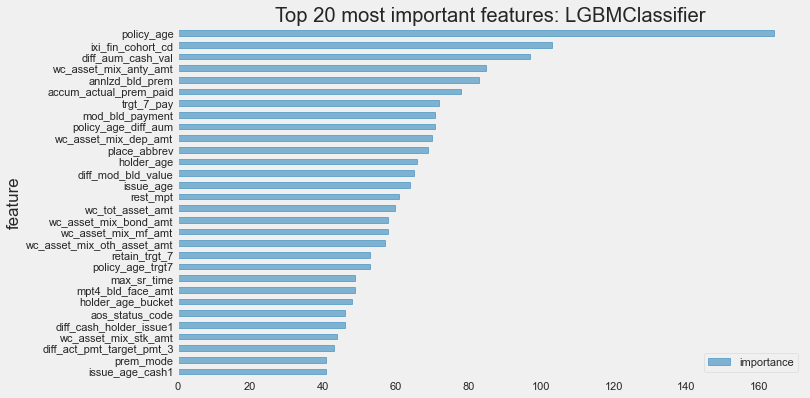

In [27]:
fn_importance_features(clf)

### in-sample fit

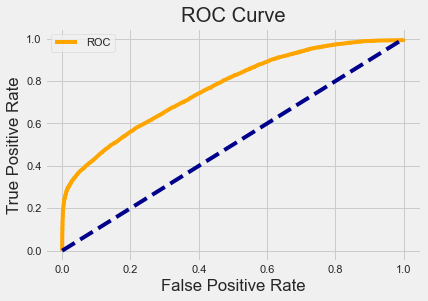

ROC value of:76.56
Accuracy:99.75
F1 score:10.10
Recall:5.95
Precision:33.41

 clasification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   3273792
           1       0.33      0.06      0.10      7647

    accuracy                           1.00   3281439
   macro avg       0.67      0.53      0.55   3281439
weighted avg       1.00      1.00      1.00   3281439



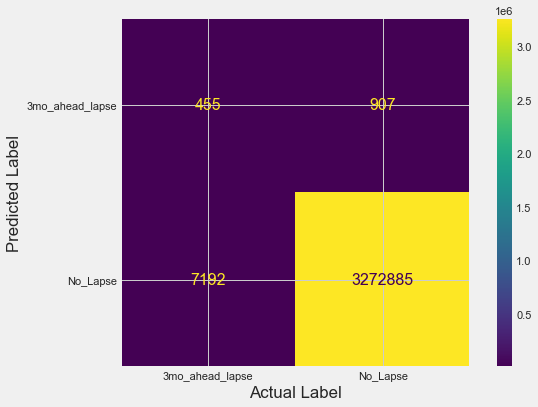

In [28]:
#### In-sample metrics
pred_Y_in = clf.predict(train_X)
pred_Y_prob_in = clf.predict_proba(train_X)[:,1]
tuned_lgb_prob_in = [train_Y, pred_Y_prob_in]
fn_metrics(train_Y, pred_Y_prob_in, pred_Y_in)

In [29]:
# # ## in-sample results 
# df_in_predict = pd.DataFrame({'prob': pred_Y_prob_in, 'predict': pred_Y_in}, columns=['prob', 'predict'], index = train_X.index.copy())

# # # Build scored dataset
# results_in = df.join(df_in_predict, how='right')

### out-of-sample fit

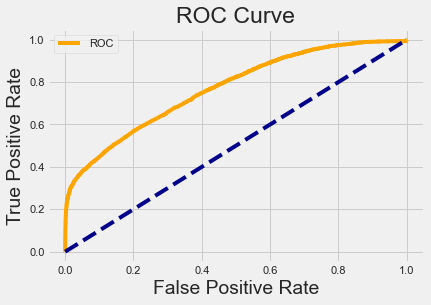

ROC value of:76.90
Accuracy:99.75
F1 score:9.60
Recall:5.63
Precision:32.52

 clasification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1636919
           1       0.33      0.06      0.10      3801

    accuracy                           1.00   1640720
   macro avg       0.66      0.53      0.55   1640720
weighted avg       1.00      1.00      1.00   1640720



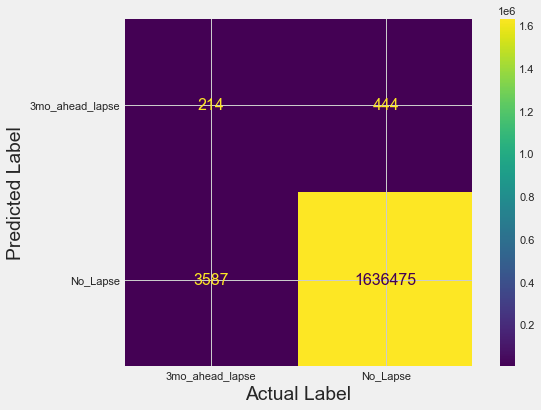

In [29]:
#Out-of-sample metrics 
pred_Y_out = clf.predict(test_X)
pred_Y_prob_out = clf.predict_proba(test_X)[:,1]
tuned_lgb_prob_out = [test_Y, pred_Y_prob_out]

#print out ROC curve, metrics, and confuction matrix
fn_metrics(test_Y, pred_Y_prob_out, pred_Y_out)

In [30]:
## out-of-sample results 
df_out_predict = pd.DataFrame({'prob': pred_Y_prob_out, 'predict': pred_Y_out}, columns=['prob', 'predict'], index = test_X.index.copy())

# Build scored dataset
score = df.join(df_out_predict, how='right')
#results_out = results_out.sort_index()

In [82]:
# sample = results_out[results_out['agmt_pkge_id']  =='R31350050000']
# sample.to_csv('sample.csv')

In [31]:
score.to_parquet('lgbm_results_out.parquet')